PROJET 1 : Segmentation et Localisation d’un Mélanome

CERCARIOLO Nils, CORTAL Tenga, MOREL Victor, PASQUESOONE Adrien

In [11]:
#IMPORTATION DES LIBRAIRIES
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import stats
import skimage.filters
import imutils
from tabulate import tabulate

In [12]:
#CHARGEMENT DES DONNÉES

melanome1 = cv2.imread("./melanome/D36_2_orig.jpg", 0)
melanome1_truth = cv2.imread("./melanome/D36_2_contour.png", 0)

melanome2 = cv2.imread("./melanome/SSM20_orig.jpg", 0)
melanome2_truth = cv2.imread("./melanome/SSM20_contour.png", 0)

melanome3 = cv2.imread("./melanome/SSM33_orig.jpg", 0)
melanome3_truth = cv2.imread("./melanome/SSM33_contour.png", 0)

In [13]:
#DÉFINITION DE LA FONCTION DICE
def dice(img1, img2):
    intersect = np.sum(img1.flatten().astype(bool)* img2.flatten().astype(bool))
    fsum = np.sum(img1.flatten().astype(bool))
    ssum = np.sum(img2.flatten().astype(bool))
    return np.mean((2*intersect)/ (fsum+ssum))

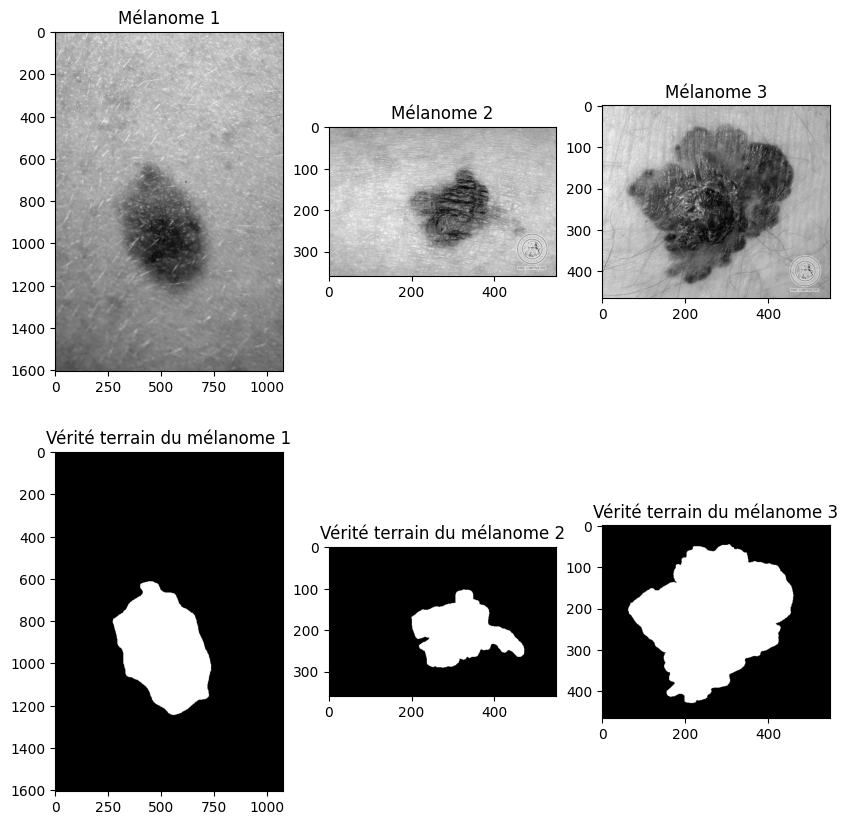

In [4]:
plt.figure(figsize=(10,10))

plt.subplot(231)
plt.title("Mélanome 1")
plt.imshow(melanome1, 'gray')

plt.subplot(232)
plt.title("Mélanome 2")
plt.imshow(melanome2, 'gray')

plt.subplot(233)
plt.title("Mélanome 3")
plt.imshow(melanome3, 'gray')

plt.subplot(234)
plt.title("Vérité terrain du mélanome 1")
plt.imshow(melanome1_truth, 'gray')

plt.subplot(235)
plt.title("Vérité terrain du mélanome 2")
plt.imshow(melanome2_truth, 'gray')

plt.subplot(236)
plt.title("Vérité terrain du mélanome 3")
plt.imshow(melanome3_truth, 'gray')

In [14]:
#DÉFINITION DES FONCTIONS

def hist_cum(img):
    img_height = img.shape[0]
    img_width = img.shape[1]
    histogram = np.zeros([256], np.int32) 
    
    for i in range(0, img_height):
        for j in range(0, img_width):
            histogram[img[i, j]] +=1
    return np.cumsum(histogram) 

def egalisation_histo(img):
    L = 256
    rows, cols = img.shape
    N = rows*cols
    res = np.zeros((rows, cols))
    hist_cumu = hist_cum(img)
    for i in range(rows):
        for j in range(cols):
            res[i,j] = (L-1)/N * hist_cumu[img[i,j]] #On utilise la formule du cours
    return res.astype(np.int16)


def thresholding(img, s):
    res = img.copy()
    res[img<=s] = 255 #Si le pixel de l'image est inférieur a notre seuil, on met un pixel blanc
    res[img> s]= 0 #Si le pixel de l'image est superieur a notre seuil, on met un pixel noir
    return res

def largest_contour(img):
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #Trouve tous les contours de l'image,
        #ne récupère que les contours extérieurs extrêmes. Compresse les segments horizontaux, verticaux et diagonaux
        #et ne laisse que leurs points d'extrémité. Par exemple, un contour rectangulaire droit est encodé avec 
        #4 points. 
    contours = imutils.grab_contours(contours) #Choisit le bon tuple pour garder les contours qui nous intéresse
    maxArea = 0
    savedContour = -1 

    for i in range(len(contours)):
        area = cv2.contourArea(contours[i]) #Calcule l'aire du contour
        if(area > maxArea): #On sélectionne la plus grande aire parmi toutes les aires des contours.
            maxArea = area
            savedContour = i 

    tmp_im = np.zeros_like(img)
    return cv2.drawContours(tmp_im, contours, savedContour, (255, 255, 255), cv2.FILLED) #On renvoit le tableau qui
        #contient l'image du contour rempli en blanc et le fond noir

def locateCenter(img):
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    maxArea = 0

    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if(area > maxArea):
            maxArea = area
            savedContour = i 

    M = cv2.moments(contours[savedContour]) #Calcule le moment du contour selectionné dans un format cv2
    cX = int(M["m10"] / M["m00"]) #On calcule le centre de l'axe X 
    cY = int(M["m01"] / M["m00"]) #On calcule le centre de l'axe Y
    center = (cX, cY)
    return center #On renvoit le centre

def traitement_melanome(img):
    power = 0.4 #On choisit cette puissance de manière empirique car c'est celle qui donne le meilleur résultat
        #tout en restant proche de la racine cubique qui fait un effet similaire au logarithme
    img_contrast_enhanced = egalisation_histo((img**power).astype('uint8')).astype('uint8') #On égalise le contraste
    img_gauss = cv2.GaussianBlur(img_contrast_enhanced, (25, 25), 0) #On applique un filtre gaussien de taille 25x25
    return thresholding(img_gauss, round(np.mean(egalisation_histo(img_gauss)))) #On renvoit le seuillage de l'image
        #filtrée avec comme seuil, la moyenne de l'histogramme égalisé de l'image filtrée.

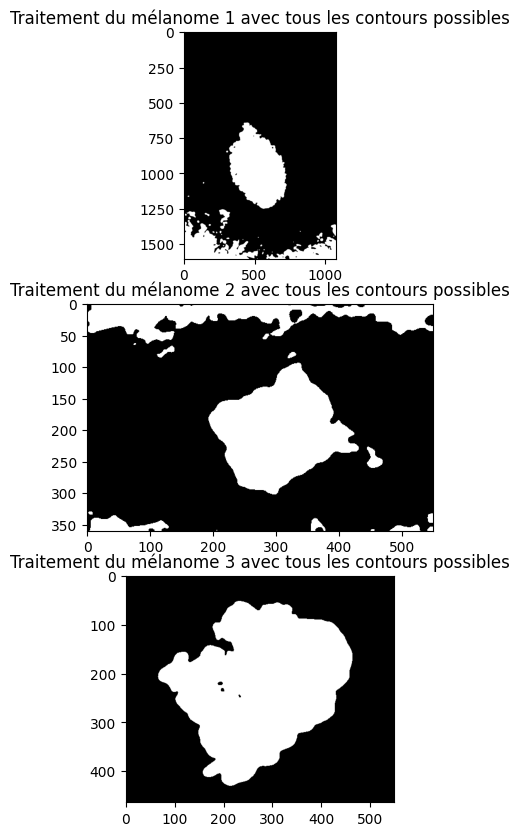

In [18]:
plt.figure(figsize=(10,10))

plt.subplot(311)
plt.title("Traitement du mélanome 1 avec tous les contours possibles")
plt.imshow(traitement_melanome(melanome1), 'gray')

plt.subplot(312)
plt.title("Traitement du mélanome 2 avec tous les contours possibles")
plt.imshow(traitement_melanome(melanome2), 'gray')

plt.subplot(313)
plt.title("Traitement du mélanome 3 avec tous les contours possibles")
plt.imshow(traitement_melanome(melanome3), 'gray')

In [19]:
#TRAITEMENT DES IMAGES

melanome1_traite = largest_contour(traitement_melanome(melanome1)) 
melanome2_traite = largest_contour(traitement_melanome(melanome2))
melanome3_traite = largest_contour(traitement_melanome(melanome3))

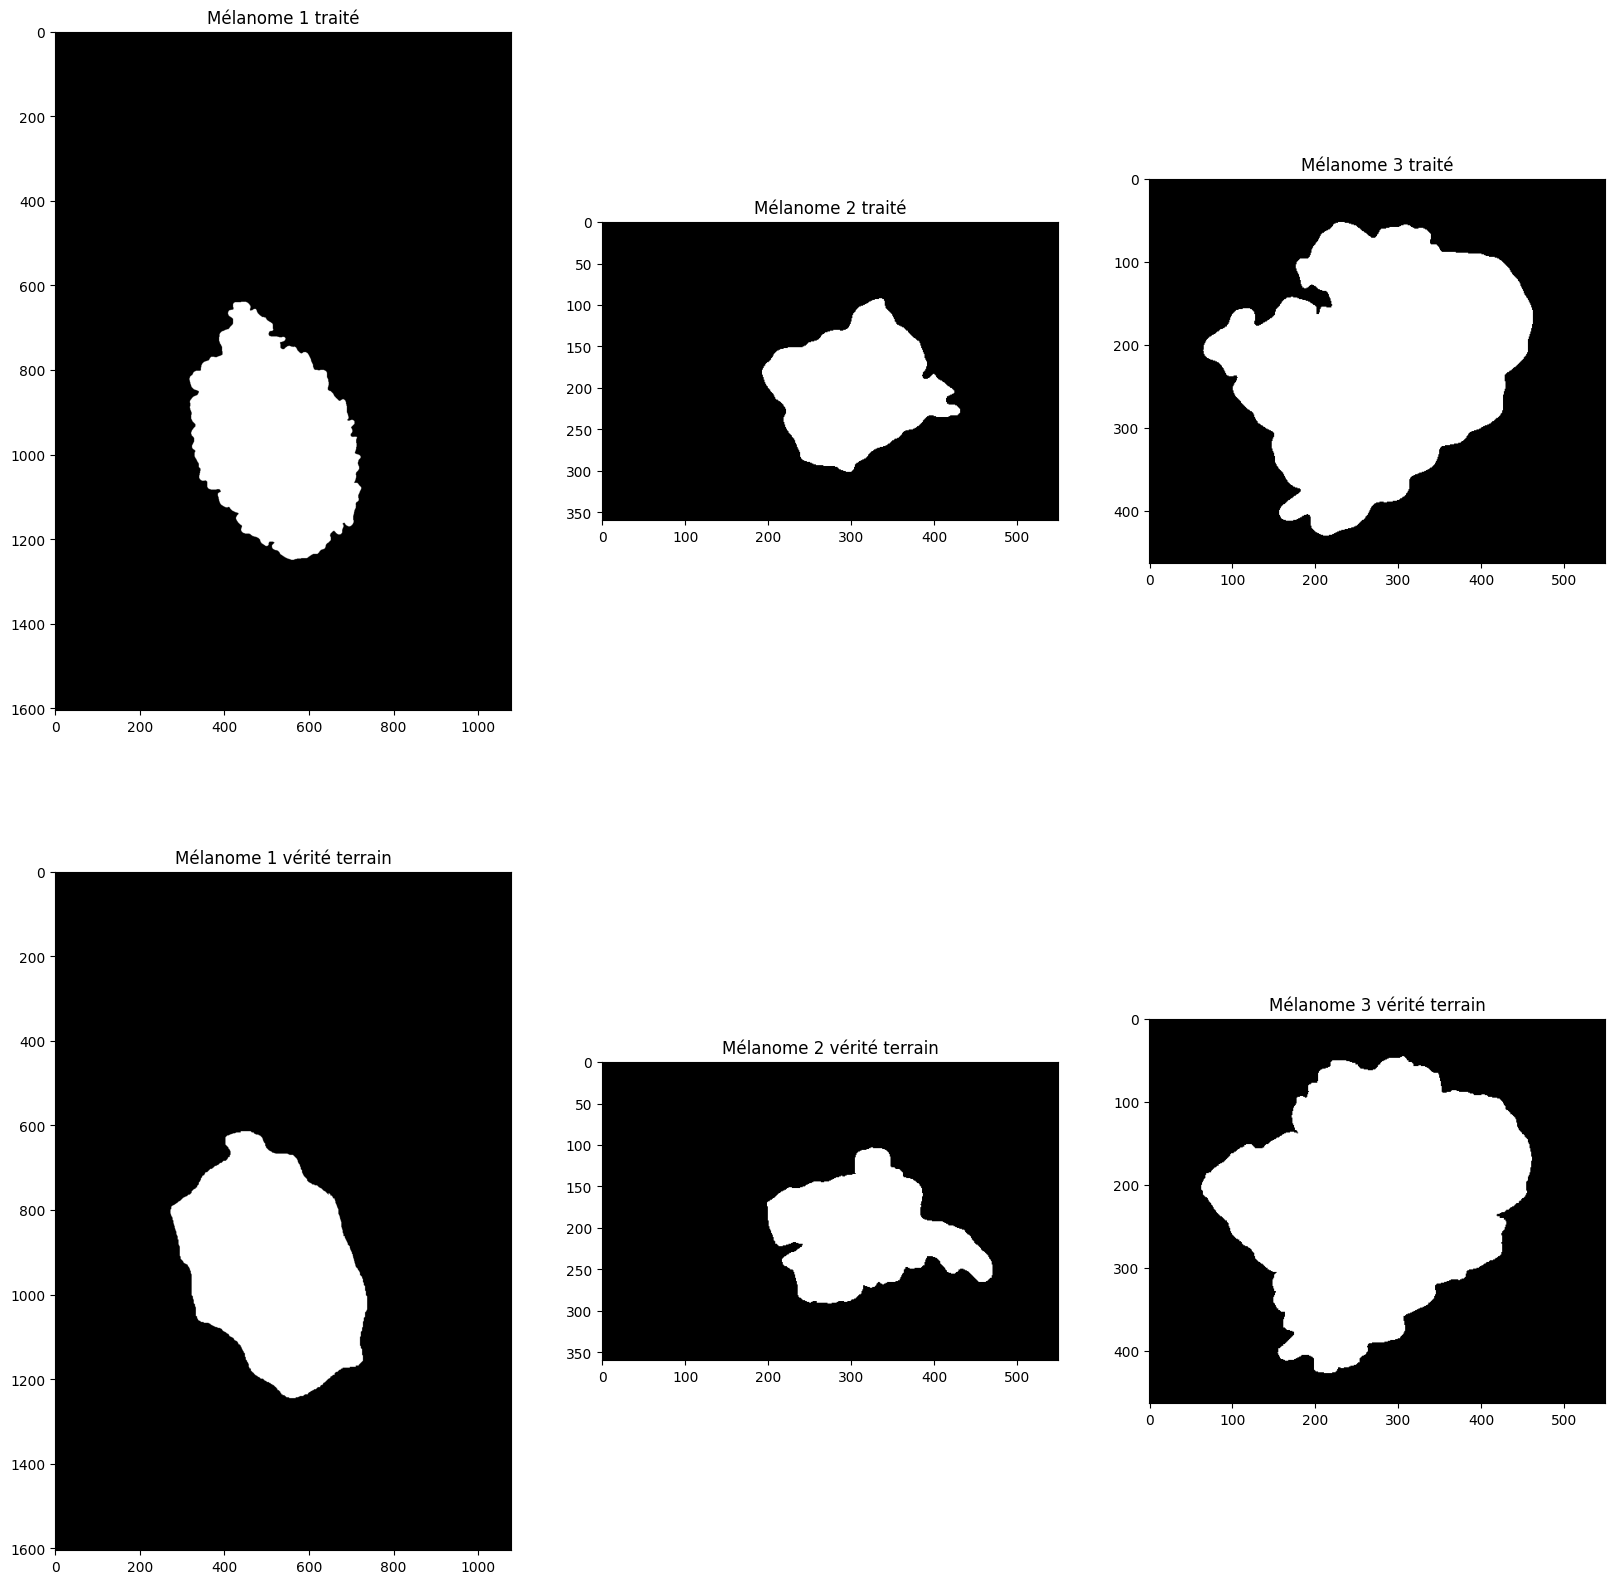

In [7]:
#AFFICHAGE DES DONNÉES

plt.figure(figsize=(20,20))

plt.subplot(231)
plt.title("Mélanome 1 traité")
plt.imshow(melanome1_traite, 'gray')

plt.subplot(234)
plt.title("Mélanome 1 vérité terrain")
plt.imshow(melanome1_truth, 'gray')

plt.subplot(232)
plt.title("Mélanome 2 traité")
plt.imshow(melanome2_traite, 'gray')

plt.subplot(235)
plt.title("Mélanome 2 vérité terrain")
plt.imshow(melanome2_truth, 'gray')

plt.subplot(233)
plt.title("Mélanome 3 traité")
plt.imshow(melanome3_traite, 'gray')

plt.subplot(236)
plt.title("Mélanome 3 vérité terrain")
plt.imshow(melanome3_truth, 'gray')

In [8]:
print(f'Dice du mélanome 1 : {dice(melanome1_truth, melanome1_traite)}')
print(f'Dice du mélanome 2 : {dice(melanome2_truth, melanome2_traite)}')
print(f'Dice du mélanome 3 : {dice(melanome3_truth, melanome3_traite)}')

Dice du mélanome 1 : 0.9019395198575326
Dice du mélanome 2 : 0.9120622847301951
Dice du mélanome 3 : 0.971018328591279


In [22]:
#CALCUL DES ERREURS RELATIVES

norme_melanome1_traite = np.linalg.norm(locateCenter(melanome1_traite))
norme_melanome1_truth = np.linalg.norm(locateCenter(melanome1_truth))

norme_melanome2_traite = np.linalg.norm(locateCenter(melanome2_traite))
norme_melanome2_truth = np.linalg.norm(locateCenter(melanome2_truth))

norme_melanome3_traite = np.linalg.norm(locateCenter(melanome3_traite))
norme_melanome3_truth = np.linalg.norm(locateCenter(melanome3_truth))
    
erreur_relative_melanome1 = np.abs(norme_melanome1_traite - norme_melanome1_truth)/norme_melanome1_truth
erreur_relative_melanome2 = np.abs(norme_melanome2_traite - norme_melanome2_truth)/norme_melanome2_truth
erreur_relative_melanome3 = np.abs(norme_melanome3_traite - norme_melanome3_truth)/norme_melanome3_truth

In [23]:
data = [["Melanome 1 traité", locateCenter(melanome1_traite)], 
        ["Melanome 1 VT", locateCenter(melanome1_truth), erreur_relative_melanome1], 
        ["Melanome 2 traité", locateCenter(melanome2_traite)], 
        ["Melanome 2 VT", locateCenter(melanome2_truth), erreur_relative_melanome2],
        ["Melanome 3 traité", locateCenter(melanome3_traite)],
        ["Melanome 3 VT", locateCenter(melanome3_truth), erreur_relative_melanome3]]
  
col_names = ["Image", "Coordonnées centres", "Erreur relative"]
  
print(tabulate(data, headers=col_names, tablefmt="grid", showindex="never"))

+-------------------+-----------------------+-------------------+
| Image             | Coordonnées centres   |   Erreur relative |
+===================+=======================+===================+
| Melanome 1 traité | (517, 964)            |                   |
+-------------------+-----------------------+-------------------+
| Melanome 1 VT     | (514, 935)            |         0.0252277 |
+-------------------+-----------------------+-------------------+
| Melanome 2 traité | (305, 201)            |                   |
+-------------------+-----------------------+-------------------+
| Melanome 2 VT     | (316, 205)            |         0.0302537 |
+-------------------+-----------------------+-------------------+
| Melanome 3 traité | (273, 226)            |                   |
+-------------------+-----------------------+-------------------+
| Melanome 3 VT     | (268, 221)            |         0.0202646 |
+-------------------+-----------------------+-------------------+
